Starting Training WGAN-GP...
[Epoch 0/500] [D loss: 4.6066] [G loss: 0.0063]
[Epoch 100/500] [D loss: -1.0345] [G loss: 0.6986]
[Epoch 100/500] [D loss: -1.0345] [G loss: 0.6986]
[Epoch 200/500] [D loss: -0.4014] [G loss: -0.3023]
[Epoch 200/500] [D loss: -0.4014] [G loss: -0.3023]
[Epoch 300/500] [D loss: -0.1000] [G loss: 0.7492]
[Epoch 300/500] [D loss: -0.1000] [G loss: 0.7492]
[Epoch 400/500] [D loss: -0.0395] [G loss: -0.4980]
[Epoch 400/500] [D loss: -0.0395] [G loss: -0.4980]
Generating 64 Combinatorial Scenarios...
Generating 64 Combinatorial Scenarios...
Data Synthetic Berhasil Disimpan: synthetic_traffic_64scenarios.csv
Plotting PCA and t-SNE...
Data Synthetic Berhasil Disimpan: synthetic_traffic_64scenarios.csv
Plotting PCA and t-SNE...
Visualisasi disimpan sebagai 'wgan_validation_plot.png'
Visualisasi disimpan sebagai 'wgan_validation_plot.png'


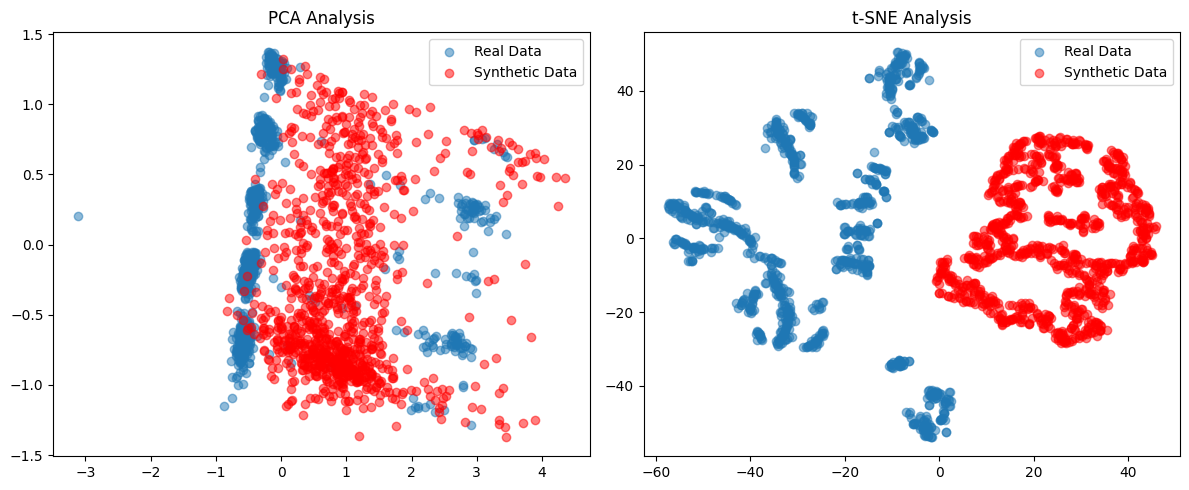

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
def load_and_clean_data(file_path):
    # Membaca CSV dengan separator ; dan decimal ,
    # File ini punya format aneh dimana setiap baris dibungkus quotes
    # Kita baca manual dan clean dulu
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
    
    # Remove quotes dari setiap baris
    cleaned_lines = [line.strip().strip('"') for line in lines]
    
    # Write ke temporary file
    import tempfile
    with tempfile.NamedTemporaryFile(mode='w', suffix='.csv', delete=False) as tmp:
        tmp.write('\n'.join(cleaned_lines))
        tmp_path = tmp.name
    
    # Baca CSV yang sudah bersih
    df = pd.read_csv(tmp_path, sep=';', decimal=',')
    
    # Hapus temporary file
    import os
    os.unlink(tmp_path)
    
    # Cek apakah ada kolom timestamp, jika ya hapus
    if 'timestamp' in df.columns:
        df_numeric = df.drop(columns=['timestamp'])
    else:
        # Jika tidak ada, semua kolom sudah numeric
        df_numeric = df
    
    # Identifikasi kolom per port untuk mapping skenario
    # Kita asumsikan data asli mayoritas adalah skenario 'Normal' (Label 0)
    features = df_numeric.values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_features = scaler.fit_transform(features)
    
    return scaled_features, scaler, df_numeric.columns

# ==========================================
# 2. MODEL ARCHITECTURE (WGAN-GP)
# ==========================================
class Generator(nn.Module):
    def __init__(self, latent_dim, cond_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, output_dim),
            nn.Tanh() # Output di range [-1, 1] sesuai scaler
        )

    def forward(self, z, labels):
        # Gabungkan noise (z) dengan condition vector (labels)
        gen_input = torch.cat((z, labels), -1)
        return self.model(gen_input)

class Critic(nn.Module):
    def __init__(self, input_dim, cond_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img, labels):
        critic_input = torch.cat((img, labels), -1)
        return self.model(critic_input)

# ==========================================
# 3. TRAINING UTILS (Gradient Penalty)
# ==========================================
def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = torch.ones(real_samples.size(0), 1)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# ==========================================
# 4. MAIN EXECUTION
# ==========================================
# Hyperparameters
latent_dim = 100
n_epochs = 500 # Bisa ditingkatkan untuk akurasi lebih tinggi
batch_size = 64
lr = 0.0001
lambda_gp = 10
n_critic = 5

# Load Data
data_scaled, scaler, column_names = load_and_clean_data('dataset_dqn_rich.csv')
input_dim = data_scaled.shape[1]
cond_dim = 3 # P4, P2, P1 condition states

# Init Models
G = Generator(latent_dim, cond_dim, input_dim)
D = Critic(input_dim, cond_dim)
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.9))

# Prepare Dataset (Asumsi data awal adalah Normal [0,0,0])
real_data = torch.FloatTensor(data_scaled)
real_labels = torch.zeros(real_data.size(0), cond_dim) # Label Baseline
dataset = TensorDataset(real_data, real_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Starting Training WGAN-GP...")
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        
        # --- Train Critic ---
        optimizer_D.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = G(z, labels)
        
        real_validity = D(imgs, labels)
        fake_validity = D(fake_imgs.detach(), labels)
        gp = compute_gradient_penalty(D, imgs.data, fake_imgs.data, labels)
        
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
        d_loss.backward()
        optimizer_D.step()

        # --- Train Generator every n_critic steps ---
        if i % n_critic == 0:
            optimizer_G.zero_grad()
            gen_imgs = G(z, labels)
            g_loss = -torch.mean(D(gen_imgs, labels))
            g_loss.backward()
            optimizer_G.step()
            
    if epoch % 100 == 0:
        print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

# ==========================================
# 5. GENERATE 64 SCENARIOS (Data Augmentation)
# ==========================================
print("Generating 64 Combinatorial Scenarios...")
all_states = [0, 1, 2, 3] # N, B, O, C
scenarios = list(itertools.product(all_states, repeat=3))
samples_per_scenario = 1000

synthetic_data_list = []
synthetic_labels_list = []

G.eval()
with torch.no_grad():
    for scen in scenarios:
        z = torch.randn(samples_per_scenario, latent_dim)
        # Skenario vector [P4, P2, P1]
        cond = torch.FloatTensor([scen] * samples_per_scenario)
        gen_samples = G(z, cond).numpy()
        
        # Inverse Scaling
        gen_samples_inv = scaler.inverse_transform(gen_samples)
        
        # --- Physics-Aware Post-Processing ---
        # Kita sesuaikan Policing Rate dan Drop berdasarkan Label Skenario
        temp_df = pd.DataFrame(gen_samples_inv, columns=column_names)
        
        for idx, port in enumerate(['p4', 'p2', 'p1']):
            state = scen[idx]
            # Randomize Policing Rate & Burst (10-50%)
            base_rate = 1000000
            temp_df[f'policing_rate_kbps_{port}'] = base_rate
            burst_pct = np.random.uniform(0.1, 0.5, samples_per_scenario)
            temp_df[f'policing_burst_kbps_{port}'] = base_rate * burst_pct
            
            # Logic Rule berdasarkan State
            if state == 0: # Normal
                temp_df[f'util_rx_pct_{port}'] = np.random.uniform(0.01, 0.6, samples_per_scenario)
                temp_df[f'drop_{port}'] = 0
            elif state == 1: # Burst
                temp_df[f'util_rx_pct_{port}'] = np.random.uniform(0.6, 0.95, samples_per_scenario)
                temp_df[f'drop_{port}'] = 0
            elif state == 2: # Overload
                temp_df[f'util_rx_pct_{port}'] = np.random.uniform(1.0, 1.5, samples_per_scenario)
                temp_df[f'drop_{port}'] = np.random.uniform(10, 100, samples_per_scenario) # Packet drop terjadi
            elif state == 3: # Congested
                temp_df[f'util_rx_pct_{port}'] = np.random.uniform(0.9, 1.0, samples_per_scenario)
                temp_df[f'delay_ms_{port}'] += np.random.uniform(20, 50, samples_per_scenario) # Delay naik drastis

        synthetic_data_list.append(temp_df)
        
final_synthetic_df = pd.concat(synthetic_data_list, ignore_index=True)
final_synthetic_df.to_csv('synthetic_traffic_64scenarios.csv', index=False)
print("Data Synthetic Berhasil Disimpan: synthetic_traffic_64scenarios.csv")

# ==========================================
# 6. VISUALIZATION (PCA & t-SNE)
# ==========================================
print("Plotting PCA and t-SNE...")
# Sampling untuk visualisasi agar tidak berat
n_plot = 1000
real_sample = data_scaled[np.random.choice(data_scaled.shape[0], n_plot, replace=False)]
fake_sample = scaler.transform(final_synthetic_df.iloc[np.random.choice(len(final_synthetic_df), n_plot, replace=False)].values)

# PCA
pca = PCA(n_components=2)
pca_real = pca.fit_transform(real_sample)
pca_fake = pca.transform(fake_sample)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(np.vstack([real_sample, fake_sample]))
tsne_real = tsne_results[:n_plot]
tsne_fake = tsne_results[n_plot:]

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(pca_real[:,0], pca_real[:,1], alpha=0.5, label='Real Data')
plt.scatter(pca_fake[:,0], pca_fake[:,1], alpha=0.5, label='Synthetic Data', color='red')
plt.title('PCA Analysis')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(tsne_real[:,0], tsne_real[:,1], alpha=0.5, label='Real Data')
plt.scatter(tsne_fake[:,0], tsne_fake[:,1], alpha=0.5, label='Synthetic Data', color='red')
plt.title('t-SNE Analysis')
plt.legend()

plt.tight_layout()
plt.savefig('wgan_validation_plot.png')
print("Visualisasi disimpan sebagai 'wgan_validation_plot.png'")